In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("~/Desktop/NCSA_genomics/Python - notebooks/TSForecasting/Data/consolidatedDataForPackage.csv", sep=",") # pre-processed by removing entry "Low"
#data

In [52]:
data['Display Time'] = pd.to_datetime(data['Display Time'])
data['GlucoseValue'] = pd.to_numeric(data['GlucoseValue'])
xx = data[data['subjectId'] == "GVP01"]
xx.dtypes

Display Time    datetime64[ns]
GlucoseValue           float64
subjectId               object
dtype: object

[Text(0, 0, '2016-06-21 00:00:00'),
 Text(0, 0, '2016-06-21 00:15:00'),
 Text(0, 0, '2016-06-21 00:30:00'),
 Text(0, 0, '2016-06-21 00:45:00'),
 Text(0, 0, '2016-06-21 01:00:00'),
 Text(0, 0, '2016-06-21 01:15:00'),
 Text(0, 0, '2016-06-21 01:30:00')]

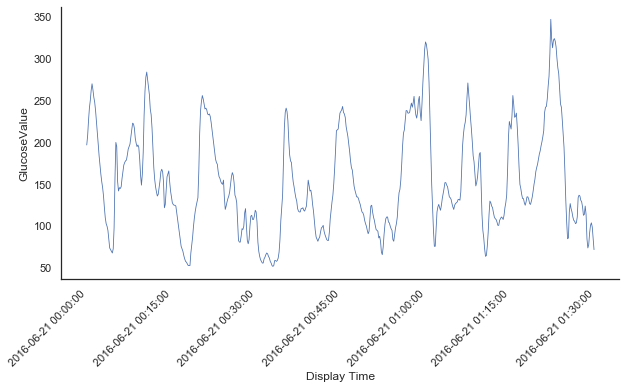

In [53]:
plt.figure(figsize=(10,5))
sns.set(style="white")
fig = sns.lineplot(x = xx.iloc[:, 0], y = xx.iloc[:, 1],
             data=xx, palette="tab10", linewidth=0.8)
sns.despine()
fig.set_xticklabels(labels=xx.iloc[:, 0], rotation=45, ha='right')



In [54]:
# Glucose Fluctuation Index and Glucose Coefficient of Fluctuation
# The GFI is based on consecutive glucose differences, where consecutive differences
# in GFI are squared prior to finding their mean and taking the square root.
# The potential benefit is that differences are weighted individually, giving more 
# importance to the greatest ones, which are likely to be more detrimental 

# GCF is computed as the ratio of GFI to the mean of input glucose values.

# DESCRIPTION: Function takes in a sequesnce of continuous glucose values, 
# and computes glucose fluctuation index (GFI) 
# and the glucose coefficient of fluctuation (GCF).
# This function accepts data given either in mmol/L or mg/dl.

# FUNCTION PARAMETERS:  x  - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings;

# RETURN: Output is Pandas dataframe that contains numeric values for GFI and GCF accordingly;

# REFERENCES:
# - Le Floch J, Kessler L (2016). “Glucose variability: comparison of 
# different indices during continuous glucose monitoring in diabetic patients.” 
# Journal of diabetes science and technology, 10(4), 885–891.
#
def gfi(x):
    N = len(x)
    S = 0
    for i in range(0,N-1):
        S = S + (x.iloc[i, 1]  - x.iloc[(i+1), 1]) ** 2
        
    gfi = np.sqrt(S/N)
    gcf = gfi/np.mean(x.iloc[:,1])
    return pd.DataFrame({'GFI':[gfi], 'GCF':[gcf]})

In [55]:
gfi(xx)

,GFI,GCF
0,12.402467,0.080996


In [56]:
# Blood Glucose Risk Index
# LBGI is a measure of the frequency and extent of low blood glucose (BG) readings;
# HBGI is a measure of the frequency and extent of high BG readings;
# BGRI is a measure for the overall risk of extreme BG equal to LBGI + HBGI.

# The LBGI has been validated as a predictor of severe hypoglycemia, while the HBGI has 
# been related to risk for hyperglycemia and HbA1c;
# Both indices demonstrate high sensitivity to changes in glycemic profiles and metabolic 
# control, as well as high sensitivity to the effects of treatment. 

# Larger values of LBGI and HBGI indicate higher risk for hypoglycemia and hyperglycemia, 
# respectively.
# Although originally derived using self-monitored blood glucose data, these parameters 
# have been adapted to continuous interstitial glucose monitoring data.
# Correlations between LBGI and subsequent hypoglycemia and between HBGI and HbA1c have 
# been reported.

# The LBGI and the HBGI are non-negative numbers; each index and their sum could range 
# theoretically between 0 and 100.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes:
# low blood glucose index (LBGI), high blood glucose index (HBGI),
# and overall blood glucose risk index (BGRI).
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x  - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings;
# units -  should be set either to "mmol" or to "mg";

# RETURN: Output is Pandas dataframe that contains numeric values for LBGI, HBGI and BGRI accordingly;
# details  LBGI is a measure of the frequency and extent of low blood glucose (BG) readings;

# REFERENCES:
# - Service FJ (2013). “Glucose variability.” Diabetes, 62(5), 1398.
# - Kovatchev BP, Clarke WL, Breton M, Brayman K, McCall A (2005).
# “Quantifying temporal glucose variability in diabetes via continuous
# glucose monitoring: mathematical methods and clinical application.”
# Diabetes technology \& therapeutics, 7(6), 849–862.
#
def bgri(x, units):    
    if (units == 'mg'):
        fBG = 1.509*((np.log(   x.iloc[:, 1]) )**1.084  - 5.381)
    elif (units=='mmol'):
        fBG = 1.509*((np.log(18*x.iloc[:, 1]) )**1.084  - 5.381)
    else:
        return print('units should be either mmol or mg')
        
    rBG = 10 * fBG ** 2 # called BG risk function
    s = np.sign(fBG)
    s_left = np.abs(s.where(s == -1, 0))
    rlBG = rBG * s_left # called BG risk function left branch
    
    s_right = s.where(s == 1, 0)
    rhBG = rBG * s_right # called BG risk function right branch
    
    LBGI = np.mean(rlBG)#1/len(rlBG)*np.sum(rlBG) # low BD index
    HBGI = np.mean(rhBG)#1/len(rhBG)*np.sum(rhBG) # high BD index
    BGRI = (LBGI + HBGI) # BG risk index
          
    return pd.DataFrame({'LBGI':[LBGI], 'HBGI':[HBGI], 'BGRI':[BGRI]})

In [57]:
bgri(xx, units = 'mg')

,LBGI,HBGI,BGRI
0,1.285964,6.67243,7.958394


In [58]:
# Glycaemic Risk Assessment Diabetes Equation
# GRADE is a score derived to summarize the degree of risk associated with a certain glucose profile.
# Qualitative risk scoring for a wide range of glucose levels inclusive of marked hypoglycemia 
# and hyperglycemia is obtained based on a committee of diabetes practitioners.
# The calculated score can range from 0 -- meaning no risk to 50 -- meaning maximal risk.
# The structure of the formula is designed to give a continuous curvilinear approximation with a nadir at 
# 4.96 mmol/L (90 mg/dL) and high adverse weighting for both hyper- and hypoglycaemia.
# The contribution of hypoglycaemia, euglycaemia and hyperglycaemia to the GRADE score is expressed as 
# percentages:  e.g.  GRADE  (hypoglycaemia%, euglycaemia%, hyperglycaemia%),
# which are defined as:

#  <3.9 mmol/L (70 mg/dL) hypoglycaemia;

#  3.9 - 7.8mmol/L (70–140 mg/dL) euglycemia;

#  and >7.8 mml/L (140 mg/dL) hyperglycemia.


# DESCRIPTION: Takes in a sequesnce of continuous glucose values 
# and computes Glycaemic Risk Assessment Diabetes Equation (GRADE) score.
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings;
# units -  should be set either to "mmol" or to "mg";

# RETURN: Output is Pandas dataframe with numeric values for GRADE and percentages expressing risk calculated 
# from hypoglycaemia, euglycaemia and hyperglycaemia;

# REFERENCES:
# - Service FJ (2013). “Glucose variability.” Diabetes, 62(5), 1398.
# - Hill N, Hindmarsh P, Stevens R, Stratton I, Levy J, Matthews D (2007). 
# “A method for assessing quality of control from glucose profiles.” 
# Diabetic medicine, 24(7), 753–758.

def grade(x, units):
    if (units == 'mg'):
        a = 18
        g = np.append(np.where(x.iloc[:, 1] <= 37)[0], np.where(x.iloc[:, 1] >= 630)[0])
        hypo = np.where(x.iloc[:, 1] < 70)[0]
        eu = np.where((x.iloc[:, 1] >= 70) & (x.iloc[:, 1]<=140))[0]
        hyper = np.where(x.iloc[:, 1] > 140)[0]
    elif (units=='mmol'):
        a = 1
        g = np.append(np.where(x.iloc[:, 1] <= 2.06)[0], np.where(x.iloc[:, 1] >= 33.42)[0])
        hypo = np.where(x.iloc[:, 1]<3.9)[0]
        eu = np.where(x.iloc[:, 1]>=3.9 & x.iloc[:, 1] <=7.8)[0]
        hyper = np.where(x.iloc[:, 1]>7.8)[0]
    else:
        return print('units should be either mmol or mg')
    
    grd = 425*( np.log10( np.log10(a*x.iloc[:, 1]) ) + 0.16) ** 2

  
    if (len(g)>0):  # GRADE is designed to operate for BG ranges between 2.06 (37 mg/dl) and 33.42 mmol/l (630 mg/dl).
        grd[g] = 50 # Values outside this range are ascribed a GRADE value of 50.

    tmp = (np.mean(grd), len(hypo)/len(x)*100, len(eu)/len(x)*100, len(hyper)/len(x)*100)
    
    return pd.DataFrame({'GRADE':[np.mean(grd)], 'HypoG%':[len(hypo)/len(x)*100], 'EuG%':[len(eu)/len(x)*100], 'HyperG%':[len(hyper)/len(x)*100]})

In [59]:
grade(xx, units='mg')

,GRADE,HypoG%,EuG%,HyperG%
0,203.294509,6.423611,45.659722,47.916667


In [60]:
# J-index
# The J-index definition includes a sandard deviation into the measurement of glycemic variability.
# This index was developed to stress the importance of the two major glycemia components: mean level 
# and variability.
# J-index can be used to describe glucose control using the following scheme:
#  - Ideal glucose control 10 ≤ J-index ≤ 20;
#  - Good glucose control 20 < J-index ≤ 30;
#  - Poor glucose control 30 < J-index ≤ 40;
#  - Lack of glucose control J-index > 40.
# Originally derived from intermittent blood glucose determinations,
# it has been adapted to continuous monitoring data too.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes J-index.
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings;
# units -  should be set either to "mmol" or to "mg";

# RETURN: Output is Pandas dataframe that contains numeric value for J-index;

# REFERENCES:
#  - Wojcicki J (1995). “J-index. A new proposition of the assessment of current glucose 
# control in diabetic patients.” Hormone and metabolic research, 27(01), 41–42.
#  - Service FJ (2013). “Glucose variability.” Diabetes, 62(5), 1398.

def j_index(x, units):
    if (units == 'mg'):
        a = 0.001
    elif (units=='mmol'):
        a = 0.324
    else:
        return print('units should be either mmol or mg')
    
    j = a*(np.mean(x.iloc[:, 1]) + np.std(x.iloc[:, 1])) ** 2
    
    return pd.DataFrame({'J-index':[j]})

In [61]:
j_index(xx, units="mg")

,J-index
0,46.658547


In [62]:
# M-value
# Originally, M-value was defined as a quantitative index of the lack of efficacy of the treatment in 
# the individual diabetic patient.
# Othervise, M-value was proposed as a result of trying to quantify the glycemic control of diabetes patients.
# It is a measure of the stability of the glucose excursions in comparison with an “ideal” 
# glucose value of 120 mg/dL; developed using six self-monitored blood glucose values over 
# 24 h in 20 patients with type-I diabetes.
# In the final M-value exression, choice of the ideal glucose/reference value is left for the user.
# The M-value is zero in healthy persons, rising with increasing glycemic variability or poorer 
# glycemic control.
# M-value, should be calculated for each individual day (i.e. over 24h).
# The formula gives greater emphasis to hypoglycemia than hyperglycemia, making it difficult 
# to distinguish between patients with either high mean glucose or high glucose variability.
# Thus the M-value is not an indicator solely of glucose variability but is a hybrid measure of
# both variability and mean glycemia.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes M-value.
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings taken e.g. over one day (24h);
# units -  should be set either to "mmol" or to "mg";
# ref_value  - gives option to set a reference value; e.g. use 120mg/dL to reflect original M-value formula,
# set to 80mg/dL for whole blood, set to 90mg/dL for plasma measurements of glucose;

# RETURN: Output is Pandas dataframe that contains numeric value for M-value.

# REFERENCES:

# - Schlichtkrull J, Munck O, Jersild M (1965). “The M-value, an index of blood-sugar control in 
# diabetics.” Acta Medica Scandinavica, 177(1), 95–102.
# - Service FJ (2013). “Glucose variability.” Diabetes, 62(5), 1398.
# - Siegelaar SE, Holleman F, Hoekstra JB, DeVries JH (2010). “Glucose variability; does it matter?” 
# Endocrine reviews, 31(2), 171–182.
#
def m_value(x, units, ref_value):
    if (units == 'mg'):
        PG = x.iloc[:, 1]
    elif (units=='mmol'):
        PG = 18*x.iloc[:, 1]
    else:
        return print('units should be either mmol or mg')
    
    if ((ref_value != 120) & (ref_value != 90) & (ref_value != 80) ):
        return print('ref_value should be set to one of these: 80, 90, 120')
    
    M_BSBS = np.abs((10*np.log(PG/ref_value))**3)

    if (len(PG)<25):
        W = np.max(PG) - np.min(PG)
        Mvalue = np.mean(M_BSBS) + W/20 
    else:
        Mvalue = np.mean(M_BSBS)

    return pd.DataFrame({'M-value':[Mvalue]})


In [63]:
m_value(xx, units = 'mg', ref_value = 120)

,M-value
0,132.79125


In [64]:
# Mean Absolute Difference
# MAD was proposed as measures of glycemic variability and derived
# from self-monitored consecutive blood glucose values over 24 h

# DESCRIPTION: Takes in a sequesnce of continuous glucose values
# and computes mean absolute difference (MAD) of consecutive blood glucose values.
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings taken e.g. over one day (24h);

# RETURN: Output is Pandas dataframe that contains numeric value for MAD.

# REFERENCES:
# - Moberg E, Kollind M, Lins P, Adamson U (1993). “Estimation of blood-glucose variability 
# in patients with insulin-dependent diabetes mellitus.” Scandinavian journal of clinical 
# and laboratory investigation, 53(5), 507–514.
def mad(x):
    MAD = np.abs(np.sum(x.iloc[:, 1].diff())/len(x))
    return pd.DataFrame({'MAD':[MAD]})


In [65]:
mad(xx)

,MAD
0,0.217014


In [66]:
# Mean Absolute Glucose Change
# The MAG is based on added-up differences between sequential blood glucose profiles
# per 24h divided by the time in hours between the first and last blood glucose measurement.
# It measures both the amplitude and frequency of oscillations.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# mean absolute glucose change (MAG).
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for MAG.

#  REFERENCES:
# - Hermanides J, Vriesendorp TM, Bosman RJ, Zandstra DF, Hoekstra JB, DeVries JH (2010). 
# “Glucose variability is associated with intensive care unit mortality.” 
# Critical care medicine, 38(3), 838–842.
#
def mag(x):
    S = np.abs(np.sum(x.iloc[:, 1].diff()))
    n = len(x)-1
    total_T = (x.iloc[n,0] - x.iloc[0, 0])/np.timedelta64(1,'h')
    MAG = S/total_T
    return pd.DataFrame({'MAG':[MAG]})

In [67]:
mag(xx)

,MAG
0,0.869565


In [68]:
# Glycemic Variability Percentage
# GVP can provide a quantitative measurement of glycemic variability over a given interval of 
# time by analyzing the length of the CGM temporal trace normalized to the duration under evaluation.
# It is expressed as a percentage above the minimum line length with zero glycemic variability.
# This metric gives equal weight to both the amplitude and frequency.
# GVP value does contain a dependency on the unit of measure of glucose (mg/dL or mmol/L)
# It is recommended to perform calculation in glucose units of mg/dL.
# Recommended sampling intervals should not exeede 15min, greater sampling intervals such as 30 or 60 min 
# are not suitable for use with the GVP metric.
# This method is best suited for CGM traces with high data recording rate and a low number of data omissions. 

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# glycemic variability percentage (GVP).
# This function accepts data given mg/dL only.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for GVP.

# REFERENCES:
# - T. A. Peyser, A. K. Balo, B. A. Buckingham, I. B. Hirsch, and A. Garcia. Glycemic variability percentage:
# a novel method for assessing glycemic variability from continuous glucose monitor data. 
# Diabetes technology & therapeutics, 20(1):6–16, 2018.

def gvp(x, units):
    if (units != 'mg'):
        return print('units can only be mg')
    
    dt = x.iloc[:, 0].diff()/np.timedelta64(1,'m') # assuming that sampling can not necessarily be equally spaced
    dy = x.iloc[:, 1].diff()
    
    L = np.sum(np.sqrt(dt**2 + dy**2))
    L_0 = np.sum(dt)
    
    GVP = (L/L_0 -1) *100
    return pd.DataFrame({'GVP(%)':[GVP]})

In [69]:
gvp(xx, units='mg')

,GVP(%)
0,23.89867


In [70]:
# Glucose Management Indicator
# GMI is calculated from a formula derived from the regression line computed from a plot 
# of mean glucose concentration points on the x-axis and contemporaneously measured A1C values 
# on the y-axis ( replacement to "estimated A1C"). It was rerived using a Dexcom sensor, threfore there is no guarantee that 
# this formula would be precisely the same for CGM data collected from a different sensor. 
# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# glycemic variability percentage (GVP).
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for GMI.

# REFERENCES:
# - R. M. Bergenstal, R. W. Beck, K. L. Close, G. Grunberger, D. B. Sacks,A. Kowalski, A. S. Brown, 
# L. Heinemann, G. Aleppo, D. B. Ryan, et al. Glucosemanagement indicator (gmi): a new term for 
# estimating a1c from continuousglucose monitoring. Diabetes care, 41(11):2275–2280, 2018

def gmi(x, units):
    if (units == 'mg'):
        GMI = 3.31 + 0.02392 * np.mean(x.iloc[:, 1])
        return pd.DataFrame({'GMI(%)': [GMI]})
    elif (units=='mmol'):
        GMI = 12.71 + 4.70587 * np.mean(x.iloc[:, 1])
        return pd.DataFrame({'GMI(%)': [GMI]})
    else:
        return print('units should be either mmol or mg')
    
    

In [71]:
gmi(xx, units='mg')

,GMI(%)
0,6.97275


In [72]:
# Largest Amplitude of Glycemic Excursions
# LAGE is the difference between the maximum and minimum glucose values within a day, 
# It is equivalent to a range in statistics and represents the single, biggest fluctuation 
# in glucose level within a day.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# glycemic variability percentage (GVP).
# This function accepts data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for LAGE, MIN, MAX.

# REFERENCES:
# - TA. Soliman, V. De Sanctis, M. Yassin, and R. Elalaily. Therapeutic use anddiagnostic potential 
# of continuous glucose monitoring systems (cgms) inadolescents.Adv Diabetes Metab, 2:21–30, 2014.
#  - M. Tao, J. Zhou, J. Zhu, W. Lu, and W. Jia. Continuous glucose monitoringreveals abnormal features 
# of postprandial glycemic excursions in women withpolycystic ovarian syndrome. 
# Postgraduate medicine, 123(2):185–190, 2011

def lage(x):
    MIN = np.min(x.iloc[:, 1])
    MAX = np.max(x.iloc[:, 1])
    LAGE = MAX - MIN
    return pd.DataFrame({'LAGE': [LAGE], 'MAX': [MAX], 'MIN':[MIN]})

In [73]:
lage(xx)

,LAGE,MAX,MIN
0,295.0,347.0,52.0


In [74]:
# Estimated HbA1c 
# Original formula is based on computing estimated glucose level using HbA1c:
# eAC = 28.7*HbA1c - 46.7. Rearranging arguments we can compute eHbA1c.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# glycemic variability percentage (GVP).
# This function works with data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for eHbA1c.

# REFERENCES:
# - G. Bozkaya, E. Ozgu, and B. Karaca. The association between estimated averageglucose
# levels and fasting plasma glucose levels.Clinics, 65(11):1077–1080, 2010
# - https://professional.diabetes.org/diapro/glucose_calc
def ehba1c(x):
        HBA1C = (np.mean(x.iloc[:, 1]) + 46.7)/28.7
        return pd.DataFrame({'eHbA1c': [HBA1C]})

In [75]:
ehba1c(xx)

,eHbA1c
0,6.962544


In [76]:
# Summary Statistics
# Produce a simple summary statistics: mean, standard deviation, coefficient of variation
# and interquartile range.
#
# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# summary statistics: mean, standard deviation, coefficient of variation
# and interquartile range.
# This function works with data given either in mmol/L or mg/dL.
#
# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.
#
# RETRUN: Output is Pandas dataframe that contains numeric value for mean, standard deviation,
# coefficient of variation and interquartile range.
#
def sumstats(x):
    m = np.mean(x.iloc[:, 1])
    sd = np.std(x.iloc[:, 1])
    cv = sd/m
    q75, q25 = np.percentile(x.iloc[:, 1], [75 ,25])
    iqr = q75 - q25
    
    return pd.DataFrame({'Mean': [m], 'SD':[sd], 'CV': [cv], 'IQR': [iqr]})

In [77]:
sumstats(xx)

,Mean,SD,CV,IQR
0,153.125,62.880895,0.410651,91.25


In [78]:
# Standard Deviation of the Glucose Rate of Change 
# Glucose rate of change is a way to evaluate the dynamics of glucose fluctuations
# on the time scale of minutes. A larger variation of the glucose rate of change indicates 
# rapid and more pronounced BG fluctuations

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# glycemic variability percentage SDRC.
# Operated on data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for SDRC.

# REFERENCES:
# - W. Clarke and B. Kovatchev. Statistical tools to analyze continuous glucosemonitor data.
# Diabetes technology & therapeutics, 11(S1):S–45, 2009.

def rc(x):
    dt = x.iloc[:, 0].diff()/np.timedelta64(1,'m') 
    dy = x.iloc[:, 1].diff()
    
    sdrc = np.std(dy/dt)
    return pd.DataFrame({'SD of RC': [sdrc]})

In [79]:
rc(xx)

,SD of RC
0,0.827423


In [80]:
# Personal Glycemic State
# The PGS is an additive composite metric calculated using the following simple equation
# PGS  = F(GVP) + F(MG) + F(PTIR) + F(H),
# where F(GVP) is a function of the glycemic variability percentage, 
# F(MG) is a function of the mean glucose, 
# F(PTIR) is a function of the percent time in range (from 70 to 180 mg/ dL), and 
# F(H) is a function of the incidence of the number of hypoglycemic episodes per week.
# The hypoglycemia function incorporates two distinct thresholds (54 and 70 mg/dL) and is 
# the sum of two terms: F54(H) and F70(H).
# PGS is computed per week and then averaged across all weeks.
# The min value of the PGS metric is 4.6 corresponding to excellent glycemic control 
# (no diabetes or patients with diabetes under superb glycemic control). 
# The max value of the PGS metric is 40 corresponding to a poor quality of glycemic control 
# that would be seen in patients with elevated A1c values, high mean glucose, and low percent of time 
# in the euglycemic range.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# glycemic variability percentage SDRC.
# Operated on data given either in mmol/L or mg/dL.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for DT.

# REFERENCES:
# -  I. B. Hirsch, A. K. Balo, K. Sayer, A. Garcia, B. A. Buckingham, and T. A.Peyser. 
# A simple composite metric for the assessment of glycemic status fromcontinuous glucose 
# monitoring data: implications for clinical practice and theartificial pancreas. 
# Diabetes technology & therapeutics, 19(S3):S–38, 2017.

def pgs(x, units):
    if (units != 'mg'):
        return print('units can only be mg')
    
    N54 = len(x[x.iloc[:,1]<=54])
    F_54H = 0.5 + 4.5 * (1 - np.exp(-0.81093*N54))
    
    N70 = len(x[x.iloc[:,1]<70]) - N54
    
    if (N70 <= 7.65):
        F_70H = 0.5714 * N70 + 0.625
    else:
        F_70H = 5
        
    F_H = F_54H + F_70H
    GVP = gvp(x, units=units)

    F_GVP = 1 + 9/(1 + np.exp(-0.049*(GVP-65.47)))
    
    
    TIR  =  len(x) - len(x[x.iloc[:,1]<70].iloc[:,1]) - len(x[x.iloc[:,1]>180].iloc[:,1])
    PTIR = TIR*100/len(x)
    
    F_PTIR = 1 + 9/(1 + np.exp(0.0833*(PTIR - 55.04)))
    
    MG = np.mean(x.iloc[:, 1])
    F_MG = 1 + 9 * ( 1/(1 + np.exp(0.1139*(MG-72.08))) + 1/(1 + np.exp(-0.09195*(MG-157.57))) )
    
    PGS = F_GVP + F_MG + F_PTIR + F_H
    PGS.columns=['PGS']
    return PGS

In [81]:
pgs(xx, units='mg')

,PGS
0,20.596373


In [82]:
# The distance traveled 
# This metric is the  sum of the absolute difference in glucose levels for one day
# of consecutive CGM readings. It does not directly calculate frequency or magnitude (amplitude) of excursions; 
# instead, it quantifies the total change in blood glucose levels throughout the day by measuring 
# the total distance from point to point in a daily CGM plot. 
# Thus the greater the distance traveled, the greater the variability.
# DT is computed for each day and then averaged across all days.

# DESCRIPTION: Takes in a sequesnce of continuous glucose values and computes
# distance traveled.

# FUNCTION PARAMETERS: x - is Pandas dataframe, in the fist column is given subject ID, 
# in the second - Pandas time stamp, and in the fird - numeric values of 
# continuous glucose readings.

# RETRUN: Output is Pandas dataframe that contains numeric value for  average DT.

# REFERENCES:
# -   D. Rodbard. Glucose variability: a review of clinical applications and research developments.
# Diabetes technology & therapeutics, 20(S2):S2–5, 2018.

def dt(x):
    dy = np.sum(np.abs(x.iloc[:, 1].diff()))
    return pd.DataFrame({'DT': [dy]})

In [83]:
dt(xx)

,DT
0,5161.0
